#**Quantum Computing Assignment#2**
#K213309

##Installing Dependencies

In [ ]:
# Library for Datasets
!pip install ucimlrepo

# Libraries for implementing VQC
!pip install qiskit
!pip install qiskit_machine_learning
!pip install qiskit_algorithms
!pip install pylatexenc

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 26.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 MB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.5/108.5 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 6.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.8/97.8 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 308.6/308.6 kB 19.0 MB/s eta 0:00:00
  Created wheel for fastdtw: filename=fastdtw-0.3.4-cp310-cp310-linux_x86_64.whl size=512549 sha256=dec3d87c3098c746d12a7e00fa56ca0828bf308bc1a18c5b15a6132af210abe1
  Stored in directory: /root/.cache/pip/wheels/73/c8/f7/c25448dab74c3acf4848bc25d51

##Creating VQC Generator Function

###Managing Imports

In [ ]:
from ucimlrepo import fetch_ucirepo

import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output

from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from qiskit.circuit.library import ZZFeatureMap, PauliFeatureMap
from qiskit_algorithms.utils import algorithm_globals
from qiskit_algorithms.optimizers import SPSA
from qiskit.primitives import Sampler
from qiskit_machine_learning.algorithms.classifiers import VQC
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector

###Retrieving Datasets & Pre-Processing

In [ ]:
def getData(id, PCA_components=-1):
  data = fetch_ucirepo(id=id)
  x = data.data.features.values
  x = MinMaxScaler().fit_transform(x)
  if (PCA_components > 0):
    x = PCA(n_components=PCA_components).fit_transform(x)
  y = data.data.targets.values.flatten()
  return x,y

###Creating Feature Map

In [ ]:
def generateFeatureMap(num_features, fmtype, reps=1):
  if fmtype == ZZFeatureMap:
    return ZZFeatureMap(feature_dimension=num_features, reps=reps)
  elif fmtype == PauliFeatureMap:
    return PauliFeatureMap(feature_dimension=num_features, reps=reps, paulis=["Z", "YY"], entanglement="full")
  else:
    return -1
# feature_map.decompose().draw(output="mpl", style="clifford", fold=20)

###Creating Custom Ansatz

In [ ]:
def generateAnsatz(ansatz, num_features, reps=1):
  return ansatz(num_features, reps)

In [ ]:
def customAnsatz1 (num_features, reps):
  parameters = ParameterVector('θ', num_features*reps)
  circuit = QuantumCircuit(num_features, name="CustomAnsatz_1")
  for i in range(reps):
    for j in range(num_features):
      circuit.ry(parameters[i*num_features+j], j)
      circuit.h(j)
    for j in range(num_features-1):
      circuit.cz(j, j+1)
    for j in range(num_features-2):
      circuit.cx(j, j+2)
    for j in range(num_features-3):
      circuit.cy(j, j+3)
  return circuit

In [ ]:
def customAnsatz2 (num_features, reps):
  parameters = ParameterVector('θ', 2*num_features*reps)
  circuit = QuantumCircuit(num_features, name="CustomAnsatz_2")
  for i in range(reps):
    for j in range(num_features):
      circuit.h(j)
      circuit.ry(parameters[i*num_features+j], j)
    for j in range(num_features-1):
      circuit.cx(j, j+1)
    for j in range(num_features):
      circuit.ry(parameters[i*num_features+j+num_features], j)
    for j in range(num_features-1):
      circuit.swap(j, j+1)
  return circuit

In [ ]:
def customAnsatz3 (num_features, reps):
  parameters = ParameterVector('θ', 3*num_features*reps)
  circuit = QuantumCircuit(num_features, name="CustomAnsatz_3")
  for i in range(reps):
    for j in range(num_features):
      circuit.ry(parameters[i*num_features+j], j)
    for j in range(num_features):
      circuit.rx(parameters[i*num_features+j+num_features], j)
    for j in range(num_features-1):
      circuit.cz(j, j+1)
    for j in range(num_features):
      circuit.rz(parameters[3*i*num_features+j], j)
  return circuit


In [ ]:
def customAnsatz4 (num_features, reps):
  parameters = ParameterVector('θ', 2*num_features*reps)
  circuit = QuantumCircuit(num_features, name="CustomAnsatz_4")
  for i in range(reps):
    for j in range(num_features):
      circuit.rx(parameters[i*num_features+j], j)
    for j in range(num_features):
      circuit.ry(parameters[i*num_features+j+num_features], j)
    for j in range(num_features-2):
      circuit.cx(j, j+1)
      circuit.cx(j+2, j+1)
    for j in range(num_features-2):
      circuit.swap(j, j+2)
  return circuit

###Creating Optimizers and Setting Simulated Instance

In [ ]:
def generateOptimizer(opt, inst, iter):
  optimizer = opt(maxiter=iter)
  sampler = inst()
  return optimizer, sampler

###Helper Functions

In [ ]:
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

###Creating VQC

In [ ]:
def generateVQC(id, PCA_components, fmtype, ansatz, reps, optimizer, inst, iter):
  algorithm_globals.random_seed = 123
  x,y = getData(id, PCA_components)
  feature_map = generateFeatureMap(num_features=x.shape[1], fmtype=fmtype, reps=reps)
  ansatz = generateAnsatz(ansatz, num_features=x.shape[1], reps=reps)
  optimizer, sampler = generateOptimizer(optimizer, inst, iter)
  vqc = VQC(
      sampler=sampler,
      feature_map=feature_map,
      ansatz=ansatz,
      optimizer=optimizer,
      callback=callback_graph,
  )
  return vqc, x, y

###Training VQC

In [ ]:
def trainVQC(vqc, x, y, trainingSize, validationSize):
  train_features, temp_features, train_labels, temp_labels = train_test_split(x, y, train_size=trainingSize, random_state=algorithm_globals.random_seed)
  val_features, test_features, val_labels, test_labels = train_test_split(x, y, train_size=validationSize, random_state=algorithm_globals.random_seed)
  global objective_func_vals
  objective_func_vals = []
  start = time.time()
  vqc.fit(train_features, train_labels)
  elapsed = time.time() - start
  print(f"Training time: {round(elapsed)} seconds\n")
  return vqc, train_features, val_features, test_features, train_labels, val_labels, test_labels

###Evaluating Metrics

In [ ]:
def evaluateVQC(vqc, train_features, val_features, test_features, train_labels, val_labels, test_labels):
  pos = np.unique(train_labels)[0]

  train_pred = vqc.predict(train_features)
  val_pred = vqc.predict(val_features)
  test_pred = vqc.predict(test_features)

  train_accuracy = accuracy_score(train_labels, train_pred)
  val_accuracy = accuracy_score(val_labels, val_pred)
  test_accuracy = accuracy_score(test_labels, test_pred)

  train_precision = precision_score(train_labels, train_pred, pos_label=pos)
  val_precision = precision_score(val_labels, val_pred, pos_label=pos)
  test_precision = precision_score(test_labels, test_pred, pos_label=pos)

  train_recall = recall_score(train_labels, train_pred, pos_label=pos)
  val_recall = recall_score(val_labels, val_pred, pos_label=pos)
  test_recall = recall_score(test_labels, test_pred, pos_label=pos)

  train_f1 = f1_score(train_labels, train_pred, pos_label=pos)
  val_f1 = f1_score(val_labels, val_pred, pos_label=pos)
  test_f1 = f1_score(test_labels, test_pred, pos_label=pos)

  print("\t\tAccuracy\tPrecision\tRecall\t\tF1 Score")
  print(f"Training\t{train_accuracy:.5f}\t|\t{train_precision:.5f}\t|\t{train_recall:.5f}\t|\t{train_f1:.5f}")
  print(f"Validation\t{val_accuracy:.5f}\t|\t{val_precision:.5f}\t|\t{val_recall:.5f}\t|\t{val_f1:.5f}")
  print(f"Testing\t\t{test_accuracy:.5f}\t|\t{test_precision:.5f}\t|\t{test_recall:.5f}\t|\t{test_f1:.5f}")

  return vqc

###Modules Fusion

In [ ]:
def runVQCModel(id, PCA_components, fmtype, ansatz, reps, opt, inst, iter, trainingSize, validationSize):
  return evaluateVQC(*trainVQC(*generateVQC(id, PCA_components, fmtype, ansatz, reps, opt, inst, iter), trainingSize, validationSize))

##Tasks

###Generating VQC with Custom Ansatz_1 for Statlog Heart Dataset using ZZFeatureMap

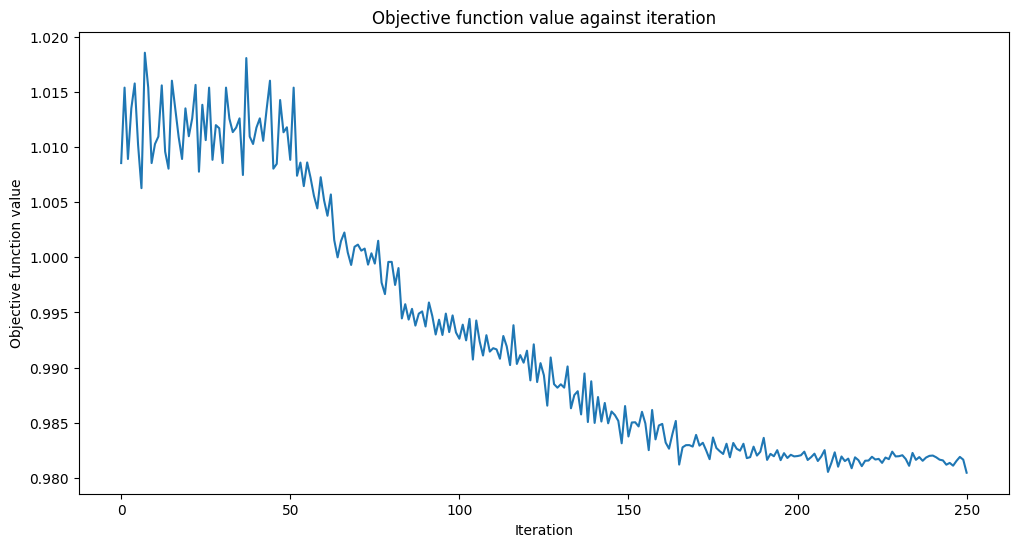

Training time: 1261 seconds

		Accuracy	Precision	Recall		F1 Score
Training	0.57143	|	0.63636	|	0.53333	|	0.58031
Validation	0.44444	|	0.71429	|	0.47619	|	0.57143
Testing		0.50617	|	0.53913	|	0.48062	|	0.50820


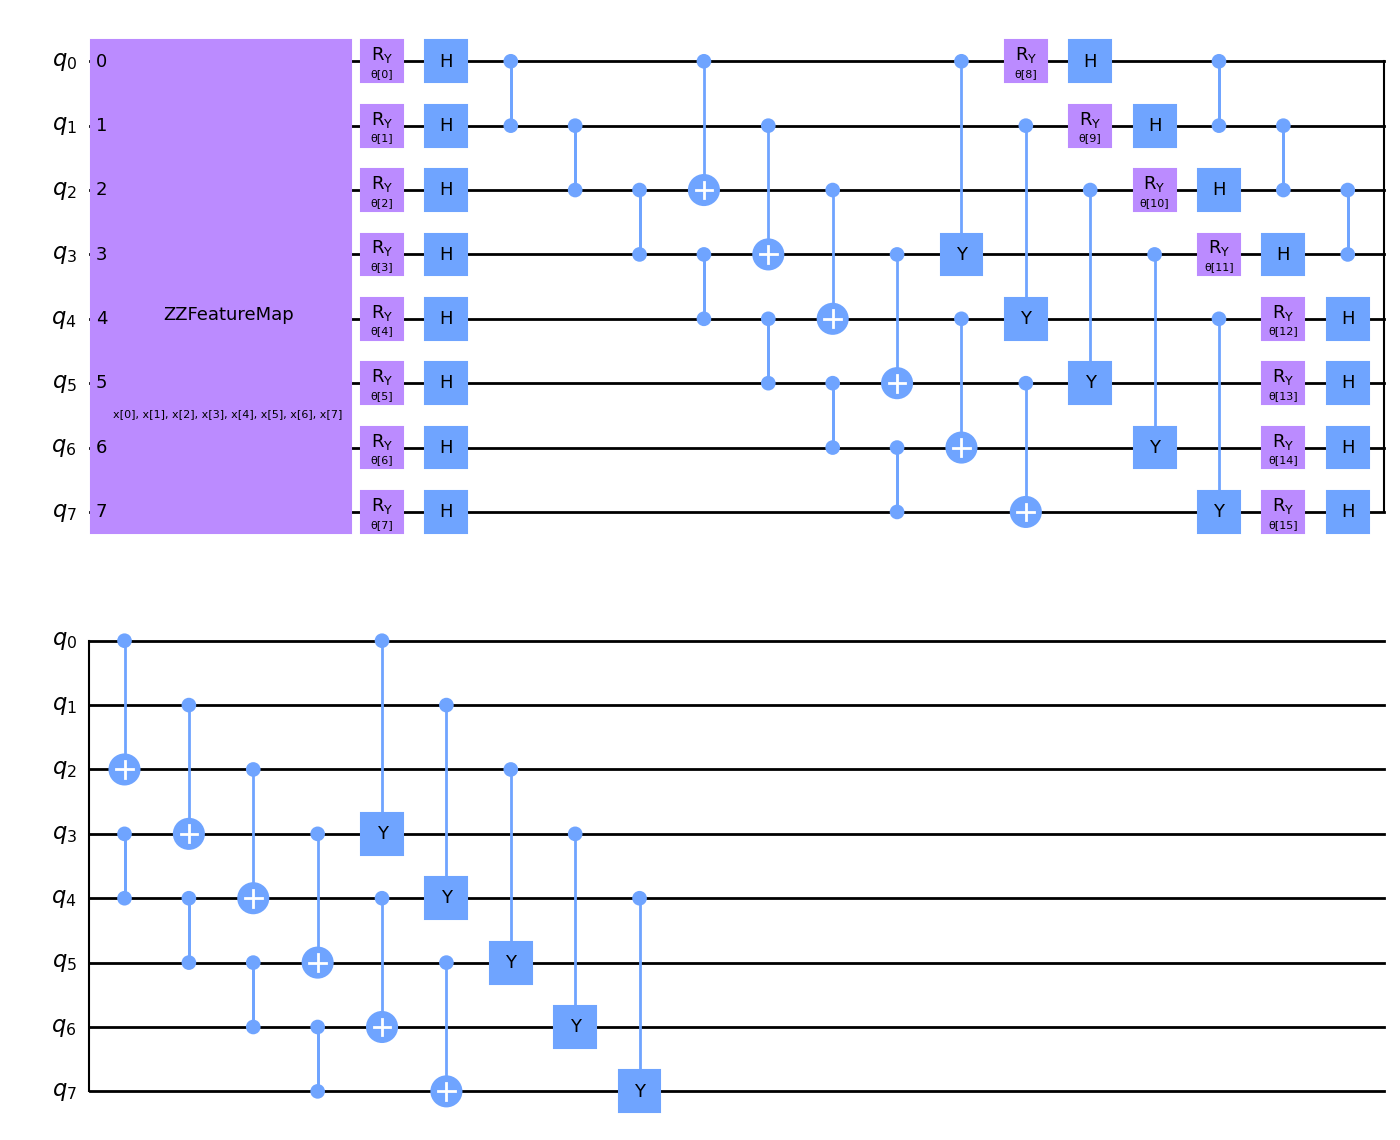

In [ ]:
vqc = runVQCModel(145, 8, ZZFeatureMap, customAnsatz1, 2, SPSA, Sampler, 100, 0.7, 0.1)
vqc.circuit.draw(output="mpl", style="clifford", fold=20)

###Generating VQC with Custom Ansatz_2 for Statlog Heart Dataset using PauliFeatureMap

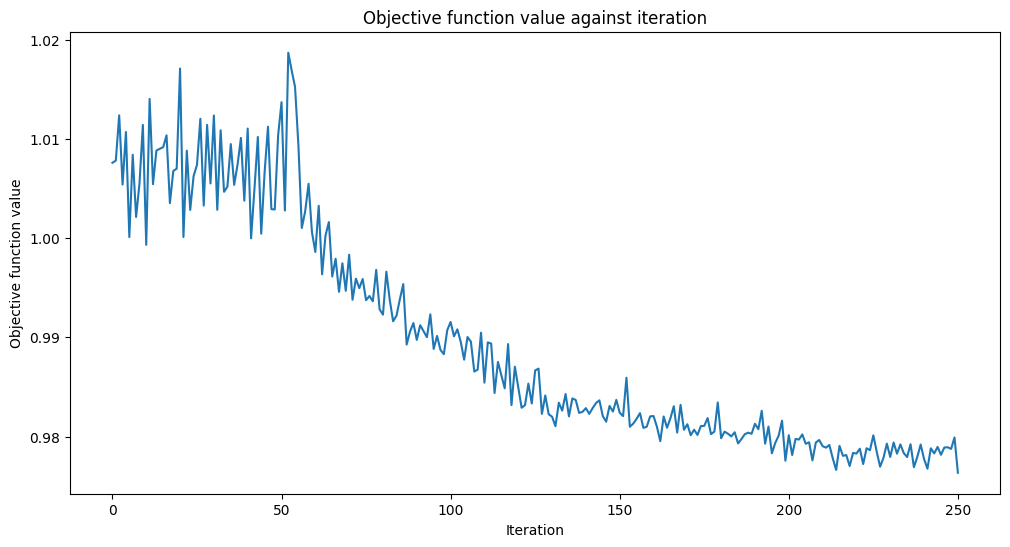

Training time: 2021 seconds

		Accuracy	Precision	Recall		F1 Score
Training	0.62434	|	0.67708	|	0.61905	|	0.64677
Validation	0.66667	|	0.87500	|	0.66667	|	0.75676
Testing		0.57613	|	0.60484	|	0.58140	|	0.59289


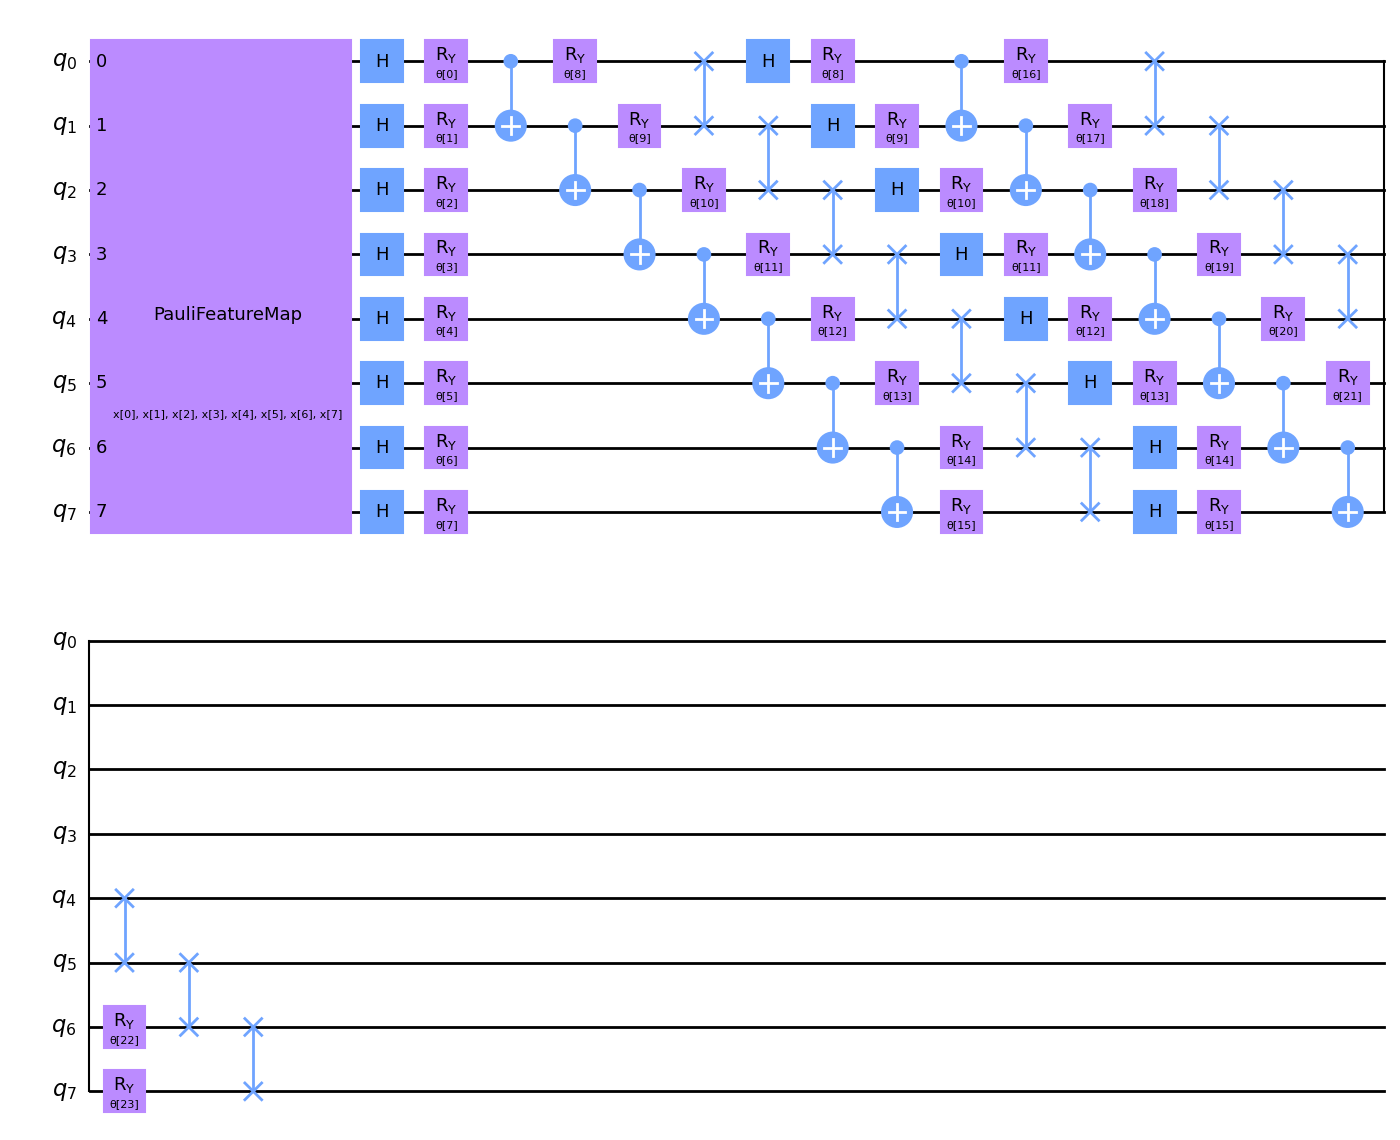

In [ ]:
vqc = runVQCModel(145, 8, PauliFeatureMap, customAnsatz2, 2, SPSA, Sampler, 100, 0.7, 0.1)
vqc.circuit.draw(output="mpl", style="clifford", fold=20)

###Generating VQC with Custom Ansatz_3 for Ionoshpere Dataset using ZZFeatureMap

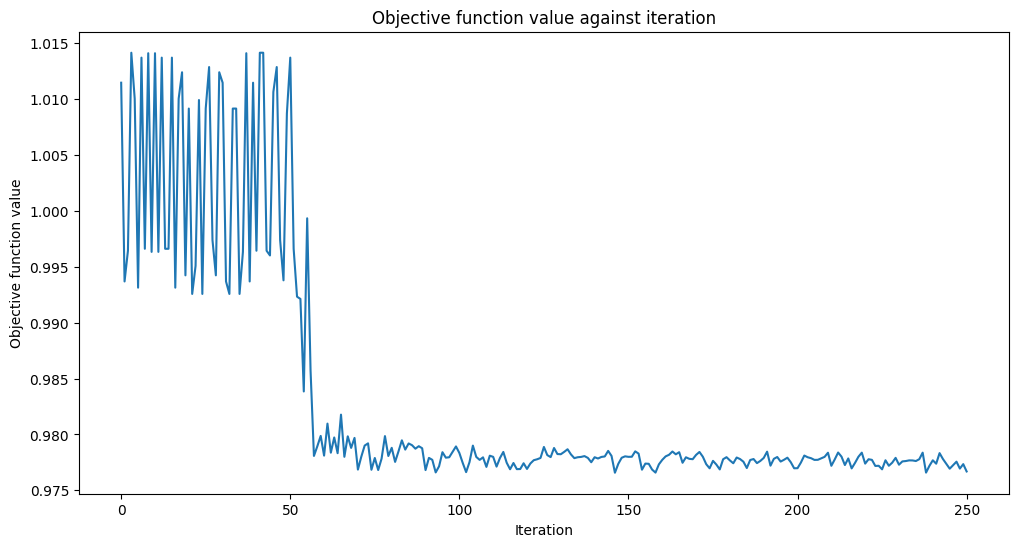

Training time: 8855 seconds

		Accuracy	Precision	Recall		F1 Score
Training	0.55102	|	0.37037	|	0.48780	|	0.42105
Validation	0.60000	|	0.56250	|	0.56250	|	0.56250
Testing		0.53481	|	0.37748	|	0.51818	|	0.43678


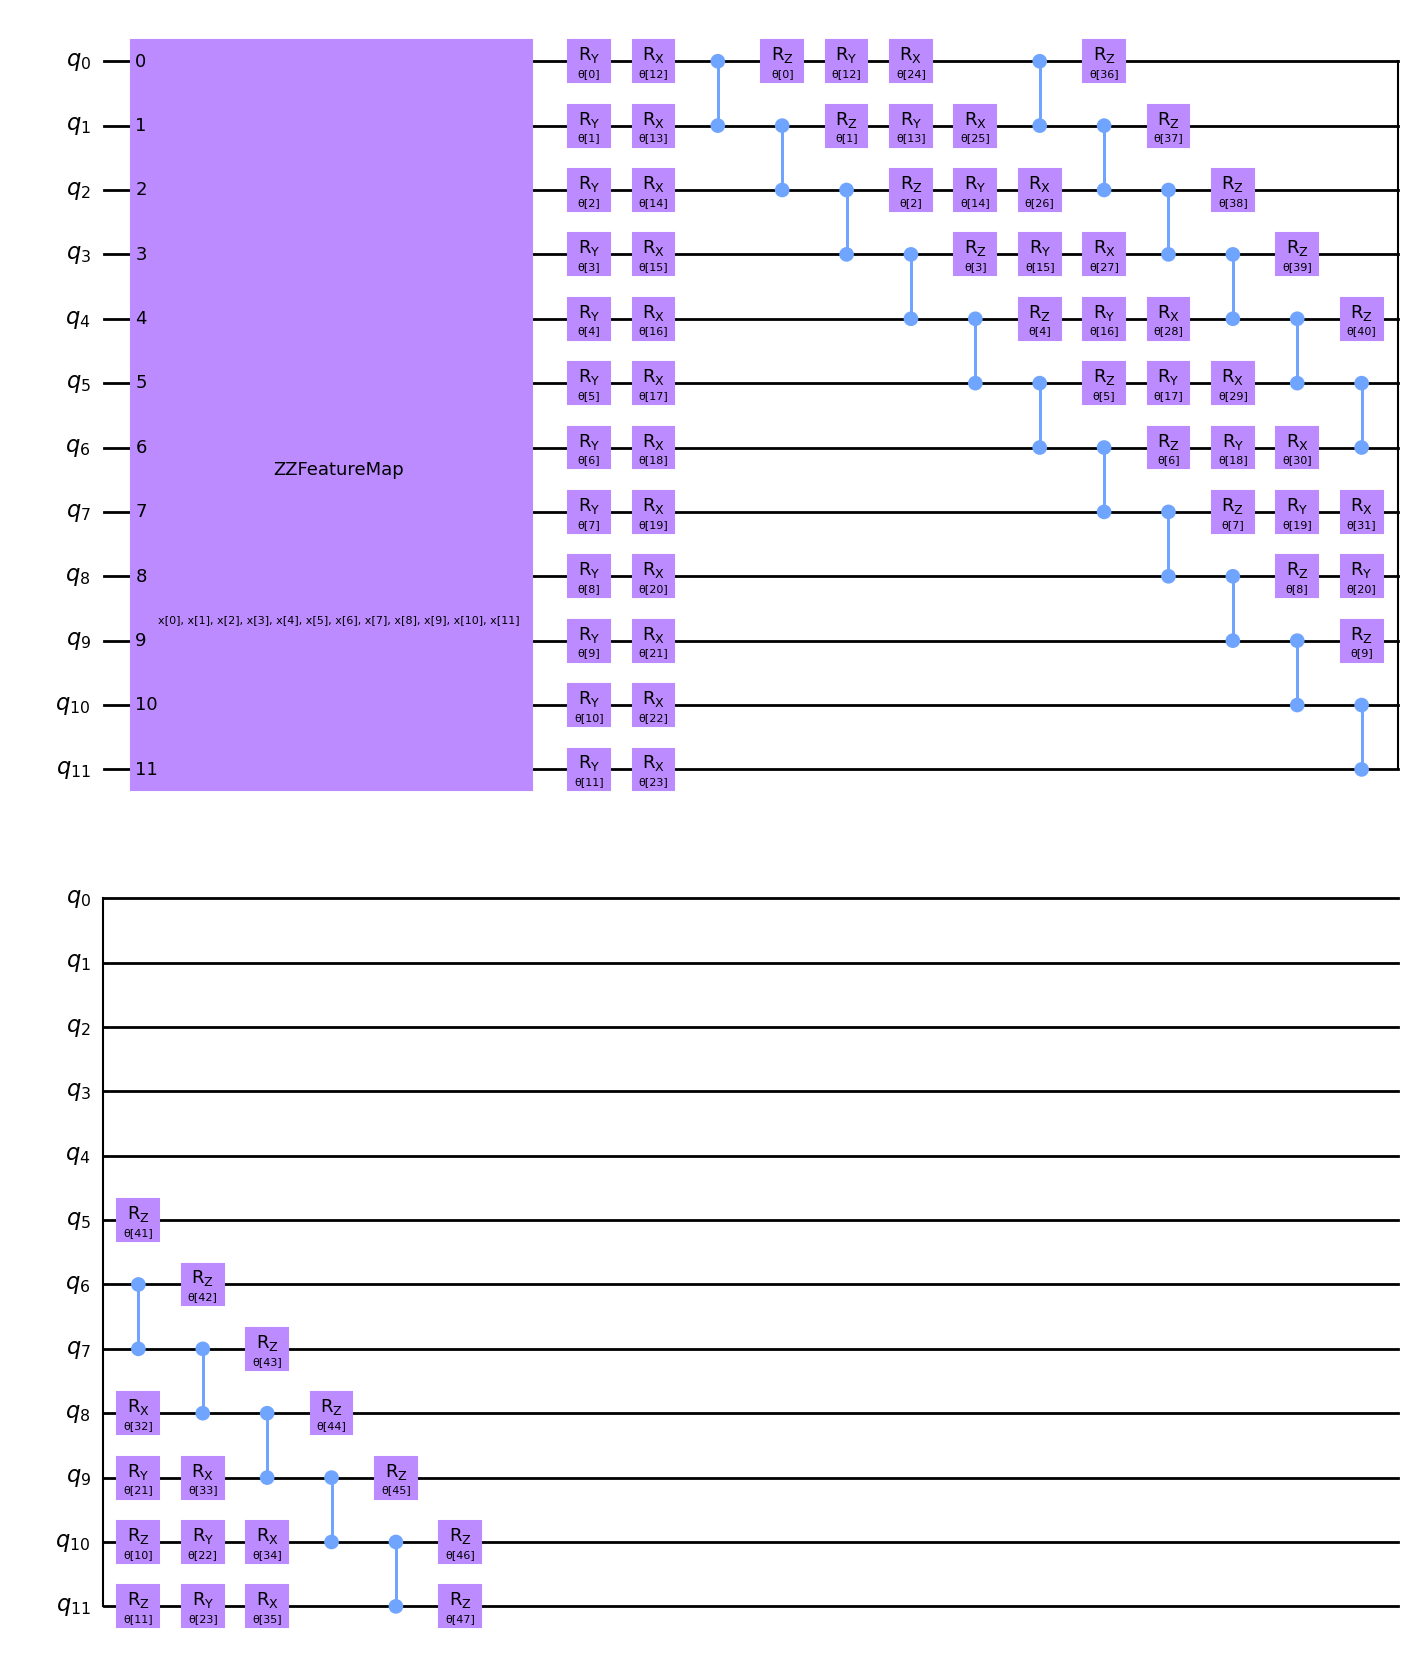

In [ ]:
vqc = runVQCModel(52, 12, ZZFeatureMap, customAnsatz3, 2, SPSA, Sampler, 100, 0.7, 0.1)
vqc.circuit.draw(output="mpl", style="clifford", fold=20)

###Generating VQC with Custom Ansatz_4 for Ionosphere Dataset using PauliFeatureMap

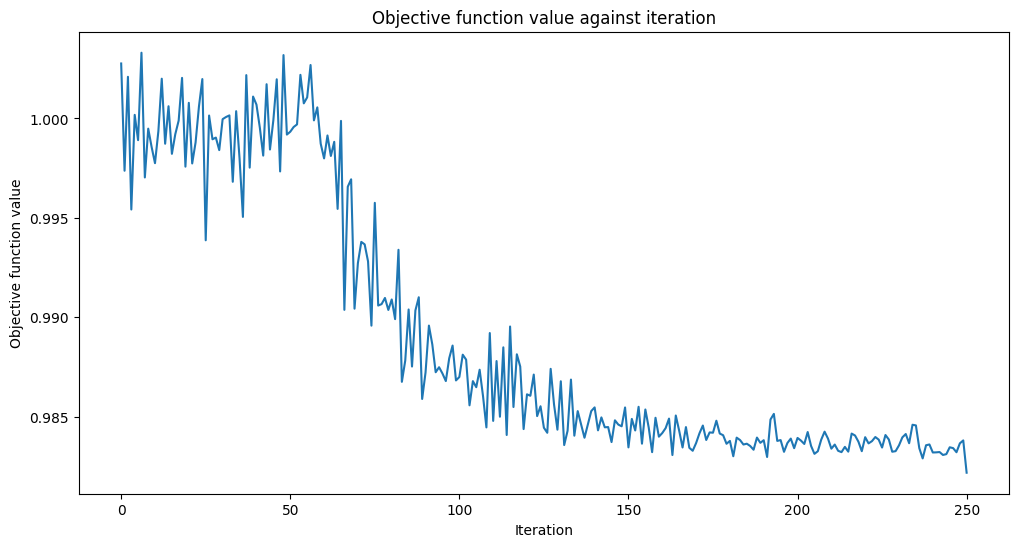

Training time: 12244 seconds

		Accuracy	Precision	Recall		F1 Score
Training	0.62449	|	0.45283	|	0.58537	|	0.51064
Validation	0.60000	|	0.55556	|	0.62500	|	0.58824
Testing		0.62658	|	0.47101	|	0.59091	|	0.52419


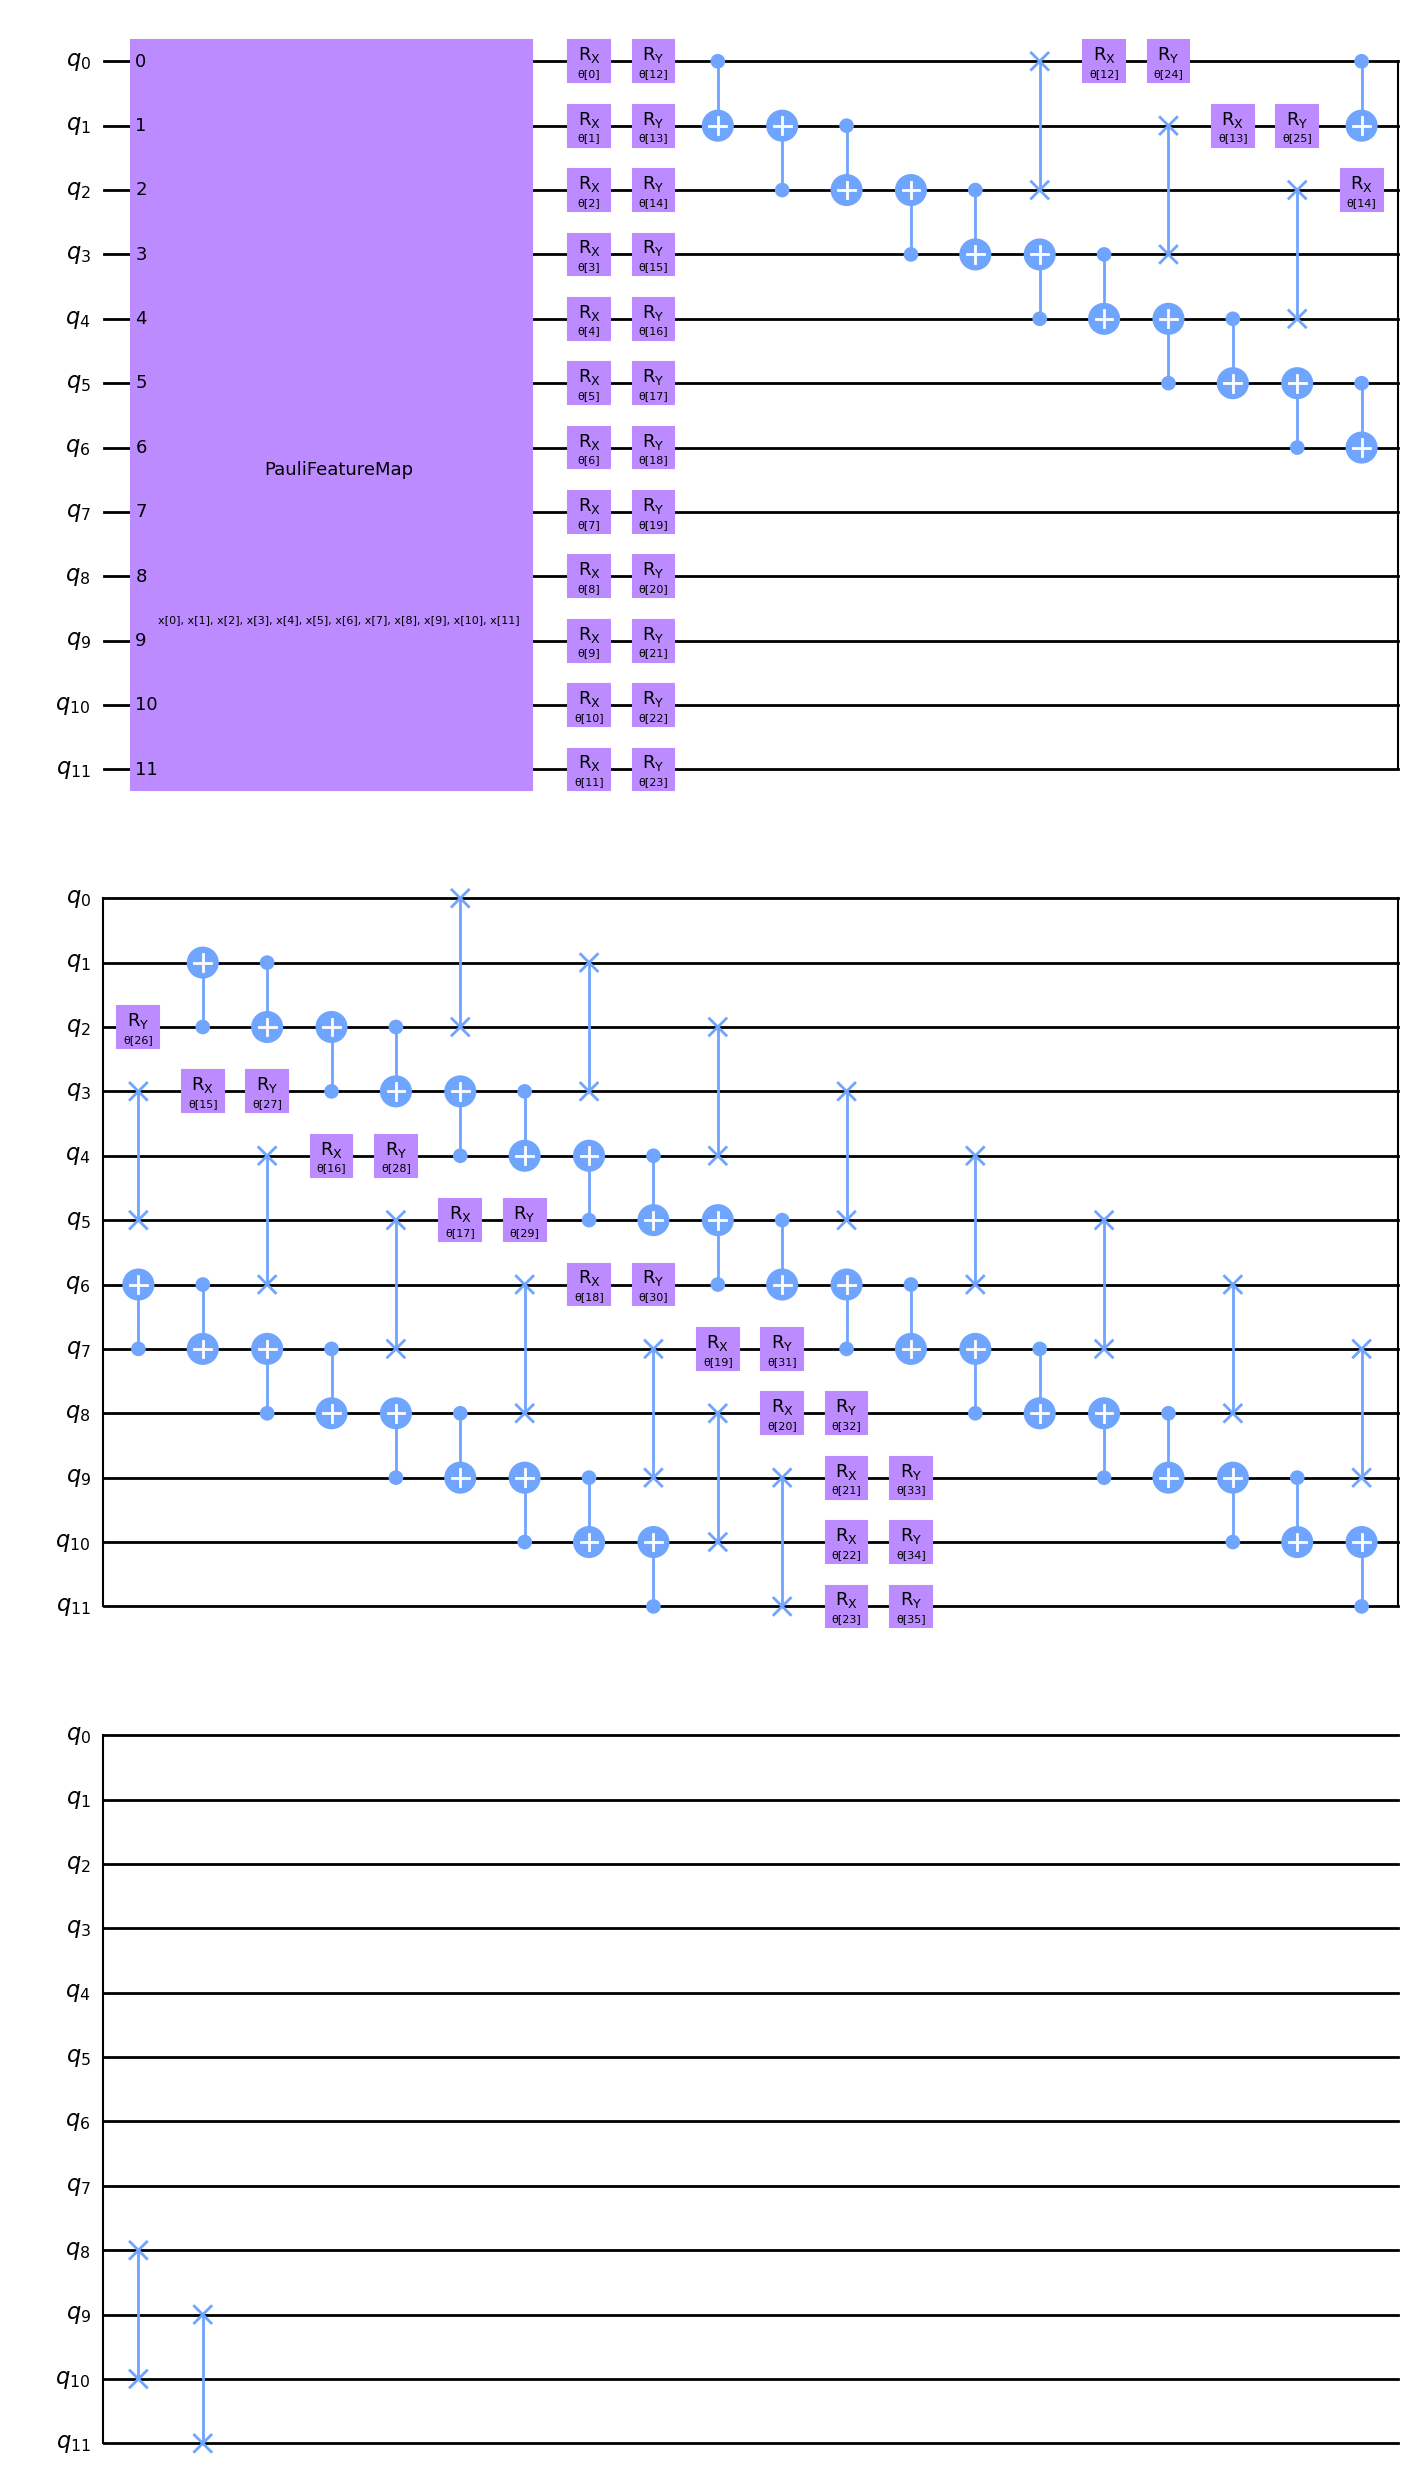

In [ ]:
vqc = runVQCModel(52, 12, PauliFeatureMap, customAnsatz4, 2, SPSA, Sampler, 100, 0.7, 0.1)
vqc.circuit.draw(output="mpl", style="clifford", fold=20)